In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
if not (os.path.exists('./data/userid-profile.tsv') and os.path.exists('./data/userid-timestamp-artid-artname-traid-traname.tsv')):
  raise ValueError('Los archivos userid-profile y userid-timestamp-artid-artname-traid-traname no fueron encontrados en el path')
else:
  print("Los archivos han sido cargados")

Los archivos han sido cargados


In [17]:
users=pd.read_csv('./data/userid-profile.tsv', sep = '\t', header=0 )

In [18]:
activity=pd.read_csv('./data/userid-timestamp-artid-artname-traid-traname.tsv', sep = '\t', names = [ 'userid', 'timestamp', 'musicbrainz-artist-id', 'artist-name', 'musicbrainz-track-id', 'track-name' ])

In [19]:
activity.count()

userid                   19098862
timestamp                19098862
musicbrainz-artist-id    18498009
artist-name              19098862
musicbrainz-track-id     16936136
track-name               19098850
dtype: int64

### Luego contamos las veces en las que usuarios escucharon un artista para encontrar el percentil 75 y descartar

In [20]:
user_artists_count = activity.groupby(['artist-name']).count()

In [21]:
sorted_user_artists_count = user_artists_count['track-name'].reset_index(name='count')

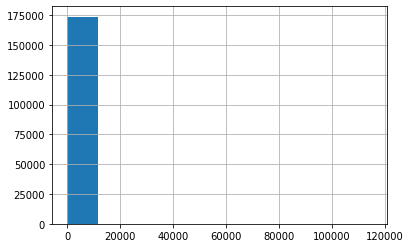

In [22]:
sorted_user_artists_count['count'].hist()

In [23]:
sorted_user_artists_count['count'].describe()

count    173923.000000
mean        109.812101
std        1116.894455
min           0.000000
25%           1.000000
50%           4.000000
75%          18.000000
max      115099.000000
Name: count, dtype: float64

### Ahora eliminamos aquellos artistas que tienen menos de 18 actividades (percentil 75)

In [24]:
noisyArtists = sorted_user_artists_count[sorted_user_artists_count['count'] <= 18]
noisyArtists = noisyArtists.loc[:,['artist-name']]

In [25]:
noisy_df = activity.merge(noisyArtists, how="inner", on="artist-name")

In [26]:
noisy_df

,userid,timestamp,musicbrainz-artist-id,artist-name,musicbrainz-track-id,track-name
0,user_000001,2009-05-03T14:56:25Z,309e2dfc-678e-4d09-a7a4-8eab9525b669,Dj Linus,4277434f-e3c2-41ae-9ce3-23fd157f9347,Good Morning Love Coffee Is Ready
1,user_000001,2009-04-28T13:35:48Z,309e2dfc-678e-4d09-a7a4-8eab9525b669,Dj Linus,4277434f-e3c2-41ae-9ce3-23fd157f9347,Good Morning Love Coffee Is Ready
2,user_000001,2009-04-26T18:54:12Z,309e2dfc-678e-4d09-a7a4-8eab9525b669,Dj Linus,4277434f-e3c2-41ae-9ce3-23fd157f9347,Good Morning Love Coffee Is Ready
3,user_000001,2009-04-26T17:24:13Z,309e2dfc-678e-4d09-a7a4-8eab9525b669,Dj Linus,4277434f-e3c2-41ae-9ce3-23fd157f9347,Good Morning Love Coffee Is Ready
4,user_000001,2009-04-11T16:24:36Z,309e2dfc-678e-4d09-a7a4-8eab9525b669,Dj Linus,4277434f-e3c2-41ae-9ce3-23fd157f9347,Good Morning Love Coffee Is Ready
...,...,...,...,...,...,...
553581,user_001000,2008-03-06T06:18:23Z,NaN,Simon Coltman,NaN,Heroes With Plimsoles
553582,user_001000,2008-03-06T06:14:54Z,NaN,Simon Coltman,NaN,Foe Future
553583,user_001000,2008-03-06T06:12:20Z,NaN,Simon Coltman,NaN,Captain Perilous
553584,user_001000,2008-03-12T05:11:57Z,8c887739-8b37-4d13-a5e4-731c0abaffc3,Burlap To Cashmere,ca1e461a-74cf-4fb0-9826-1c93f10aad55,Mansions


In [27]:
reduced_activity = pd.concat([activity, noisy_df])
reduced_activity = reduced_activity.drop_duplicates(keep=False)
reduced_activity.count()

userid                   18545274
timestamp                18545274
musicbrainz-artist-id    18164966
artist-name              18545274
musicbrainz-track-id     16719585
track-name               18545264
dtype: int64

### Calculamos la cantidad de veces que un usuario ha escuchado un artista por usuario

In [28]:
user_artists_count = activity.groupby(['userid', 'artist-name']).count()

In [29]:
sorted_user_artists_count = user_artists_count['track-name'].reset_index(name='count').sort_values(['userid', 'count'], ascending=False)
sorted_user_artists_count

,userid,artist-name,count
897402,user_001000,Wilco,455
897200,user_001000,Radiohead,444
896774,user_001000,Animal Collective,432
896943,user_001000,Girl Talk,417
896756,user_001000,Aesop Rock,383
...,...,...,...
648,user_000001,曽我部恵一,1
649,user_000001,畠山美由紀,1
652,user_000001,細野晴臣,1
654,user_000001,青柳拓次,1


### Por último sacamos un rating basado en la cantidad de veces que un artista fué escuchado de manera proporcional

In [30]:
# obtenemos un dataframe con el maximo de reproducciones por cada usuario
user_max = pd.DataFrame(sorted_user_artists_count.groupby(['userid'], sort=False)['count'].max()).reset_index()
user_max.columns = ['userid', 'max']
user_max

,userid,max
0,user_001000,455
1,user_000999,3299
2,user_000998,2535
3,user_000997,5693
4,user_000996,928
...,...,...
987,user_000005,1905
988,user_000004,542
989,user_000003,895
990,user_000002,2411


In [31]:
# hacemos merge con la tabla de usuarios y artistas
sorted_user_artists_count_max = sorted_user_artists_count.merge(user_max, how='left', left_on='userid', right_on='userid')

In [32]:
sorted_user_artists_count_max

,userid,artist-name,count,max
0,user_001000,Wilco,455,455
1,user_001000,Radiohead,444,455
2,user_001000,Animal Collective,432,455
3,user_001000,Girl Talk,417,455
4,user_001000,Aesop Rock,383,455
...,...,...,...,...
897416,user_000001,曽我部恵一,1,855
897417,user_000001,畠山美由紀,1,855
897418,user_000001,細野晴臣,1,855
897419,user_000001,青柳拓次,1,855


In [33]:
# creamos una nueva columna en el dataframe con el ranking que va de 0 a 5, donde 5 es el artista mas oido y 0 el menos oido
sorted_user_artists_count_max['rating'] = np.around((sorted_user_artists_count_max['count']/sorted_user_artists_count_max['max']) * 5, decimals=1)


In [34]:
sorted_user_artists_count_max

,userid,artist-name,count,max,rating
0,user_001000,Wilco,455,455,5.0
1,user_001000,Radiohead,444,455,4.9
2,user_001000,Animal Collective,432,455,4.7
3,user_001000,Girl Talk,417,455,4.6
4,user_001000,Aesop Rock,383,455,4.2
...,...,...,...,...,...
897416,user_000001,曽我部恵一,1,855,0.0
897417,user_000001,畠山美由紀,1,855,0.0
897418,user_000001,細野晴臣,1,855,0.0
897419,user_000001,青柳拓次,1,855,0.0


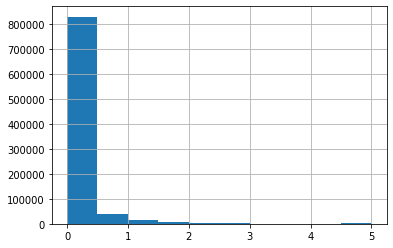

In [35]:
sorted_user_artists_count_max.rating.hist()

In [36]:
sorted_user_artists_count_max.rating.describe()

count    897421.000000
mean          0.135784
std           0.400291
min           0.000000
25%           0.000000
50%           0.000000
75%           0.100000
max           5.000000
Name: rating, dtype: float64

In [37]:
np.percentile(sorted_user_artists_count_max.rating, 95)

0.7

In [38]:
valuableRecords = sorted_user_artists_count_max[sorted_user_artists_count_max['rating'] > 0.1]
valuableRecords = valuableRecords.loc[:,['userid', 'artist-name', 'rating']]
valuableRecords

,userid,artist-name,rating
0,user_001000,Wilco,5.0
1,user_001000,Radiohead,4.9
2,user_001000,Animal Collective,4.7
3,user_001000,Girl Talk,4.6
4,user_001000,Aesop Rock,4.2
...,...,...,...
896880,user_000001,Jamie Lidell,0.2
896881,user_000001,Nick Holmes,0.2
896882,user_000001,Nuyorican Soul,0.2
896883,user_000001,The Birthday,0.2


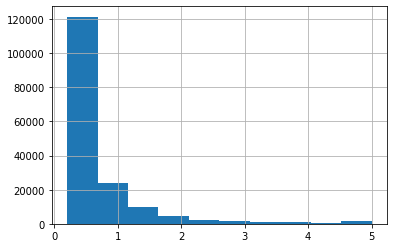

In [39]:
valuableRecords.rating.hist()

In [40]:
valuableRecords.rating.describe()

count    167494.000000
mean          0.635761
std           0.737520
min           0.200000
25%           0.200000
50%           0.400000
75%           0.700000
max           5.000000
Name: rating, dtype: float64

In [23]:
valuableRecords.to_csv('./data/preprocessed_user_item_rating.csv')